# 1. Importing libraries

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from collections import Counter 
import seaborn as sns
import re
from sklearn.neighbors import KNeighborsClassifier
import itertools
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from keras.callbacks import ModelCheckpoint



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Accessing csv file with tweets

In [82]:
df = pd.read_csv('tweets.csv',encoding='latin-1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# 3.1 Data pre-preprocessing

In [83]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.loc[df['sentiment'] == 4, 'sentiment'] = 1
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# 3.2 Data preprocessing - Natural language processing (stopwords removal and stemming)  

In [84]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [85]:
def preprocess(text):
    text = re.sub("@\S+|https?:\S+|http?:\S|\w*\d\w*|[^A-Za-z0-9]+|www?:\S", ' ', str(text).lower())
    text = text.strip()
    tokens = []
    for word in text.split():
        if word not in stop_words:
            if stemmer.stem(word) != word: #checks whether stemming is possible
                tokens.append(stemmer.stem(word))
            else:
                tokens.append(word)
    return " ".join(tokens)

In [86]:
df.text = df.text.apply(lambda x: preprocess(x))
df.head()
#df.text = df.text.apply(preprocess)

,sentiment,text
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


# 4. Most often occuring words

In [87]:
positive_tweets = df[df.sentiment == 1]
negative_tweets = df[df.sentiment == 0]

Text(0.5, 1.0, 'Top 15 Most Occurring Words in Positive Tweets')

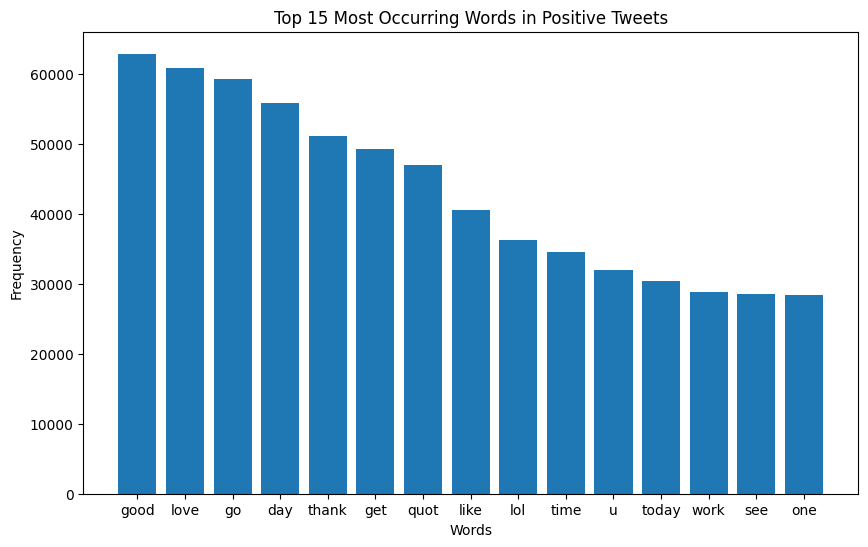

In [88]:
pos_words = " ".join(positive_tweets.text)
pos_words = pos_words.split() 

pos_words_freq = Counter(pos_words)

most_occur = pos_words_freq.most_common(15) 
words, frequencies = zip(*most_occur)
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Occurring Words in Positive Tweets')


Text(0.5, 1.0, 'Top 15 Most Occurring Words in negative Tweets')

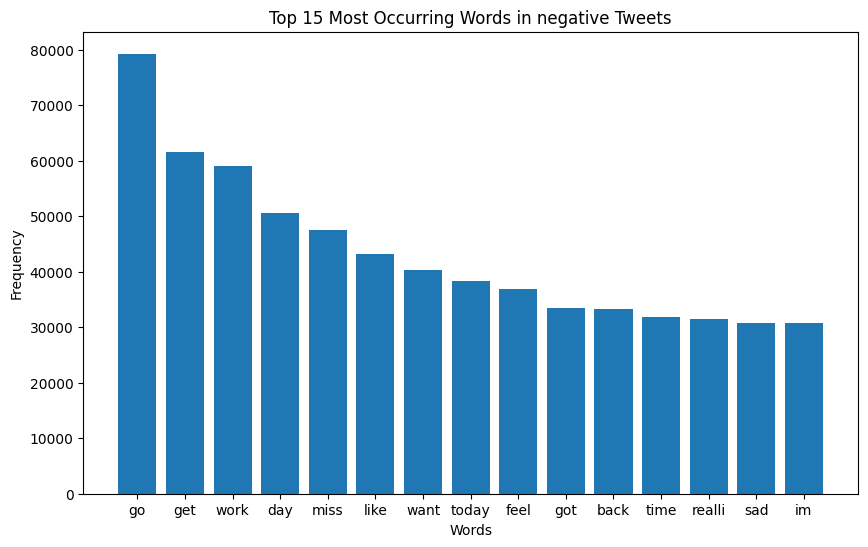

In [89]:
neg_words = " ".join(negative_tweets.text)
neg_words = neg_words.split() 

neg_words_freq = Counter(neg_words)
most_occur2 = neg_words_freq.most_common(15)
words2, frequencies2 = zip(*most_occur2)
plt.figure(figsize=(10, 6))
plt.bar(words2, frequencies2)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Occurring Words in negative Tweets')

# 5. Logistic regression and naive bayes model creation + checking which words have the biggest "power" according to tfidf

In [90]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000000000)
X = tfidf_vectorizer.fit_transform(df['text'])


In [91]:
y = df['sentiment']


In [107]:
# Splitting into test and train set (default)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#Logistic regression default model
model = LogisticRegression(max_iter=10000000)
model.fit(X_train, y_train)



LogisticRegression(max_iter=10000000)

In [108]:
#Naive Bayes default model
model2 = MultinomialNB()
model2.fit(X_train, y_train)

MultinomialNB()

## 5.1 Which words make tweets positive/negative

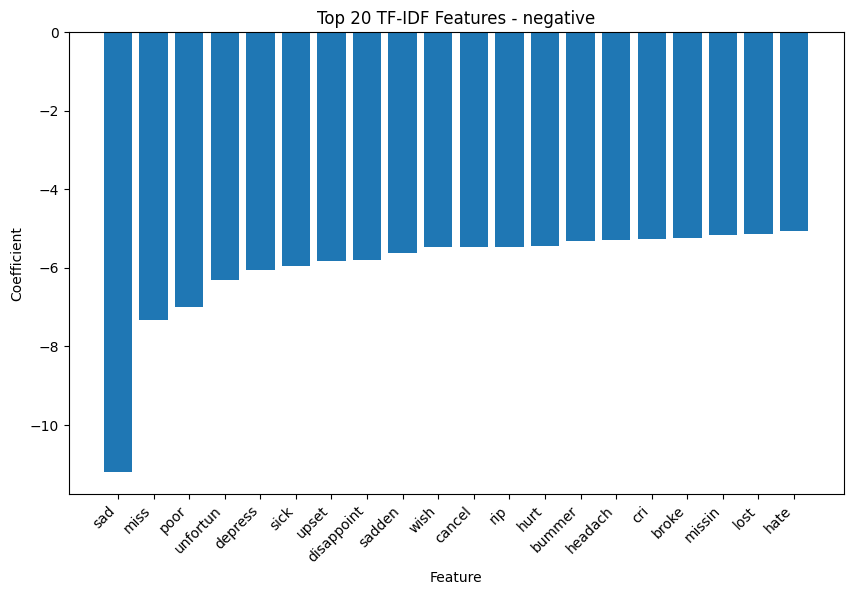

In [109]:

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_.flatten()

# Create a df to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=True)

# Display top 20 most important features
top_features = feature_importance_df.head(20)  # Adjust N as needed
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 TF-IDF Features - negative')
plt.xticks(rotation=45, ha='right')
plt.show()

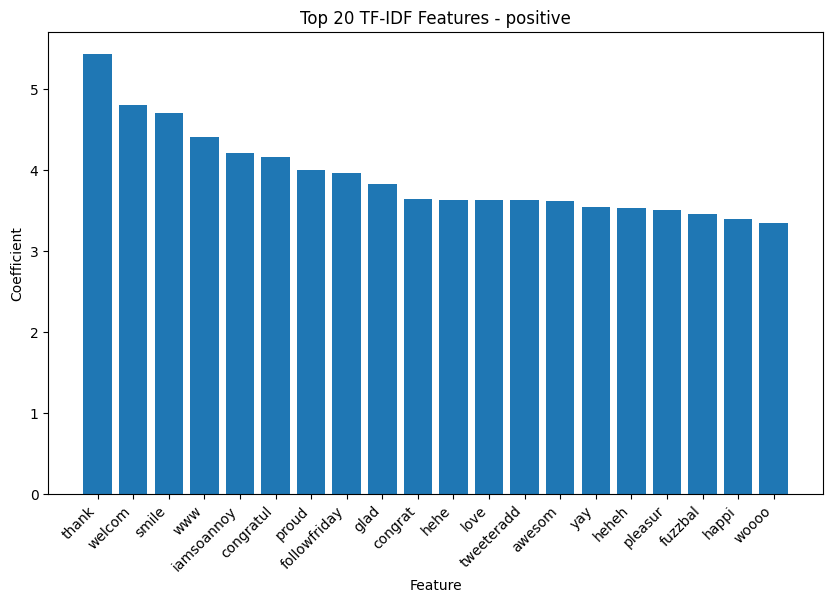

In [110]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_.flatten()

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)

top_features = feature_importance_df.head(20) 
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Top 20 TF-IDF Features - positive')
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Model evaluation logistic regression and naive bayes

In [111]:
y_pred = model.predict(X_test)
accuracy1 = accuracy_score(y_test, y_pred)

print(f'Accuracy - logistic regression: {accuracy1:.2f}')

print(classification_report(y_test, y_pred))
conf_matrix1 = confusion_matrix(y_test, y_pred)

Accuracy - logistic regression: 0.77
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    160076
           1       0.76      0.80      0.78    159924

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [112]:
y_pred2 = model2.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)

print(f'Accuracy - Naive bayes: {accuracy2:.2f}')

print(classification_report(y_test, y_pred2))
conf_matrix2 = confusion_matrix(y_test, y_pred2)

Accuracy - Naive bayes: 0.76
              precision    recall  f1-score   support

           0       0.75      0.76      0.76    160076
           1       0.76      0.75      0.75    159924

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



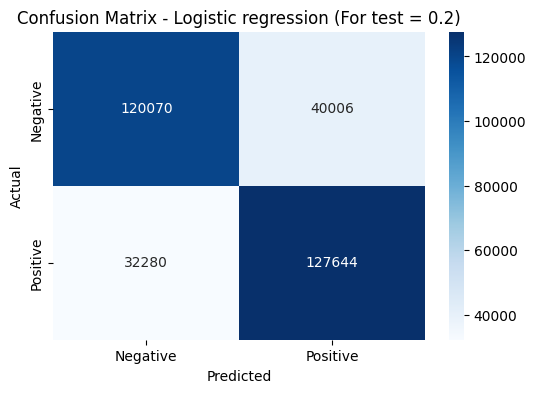

In [113]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic regression (For test = 0.2)')
plt.show()

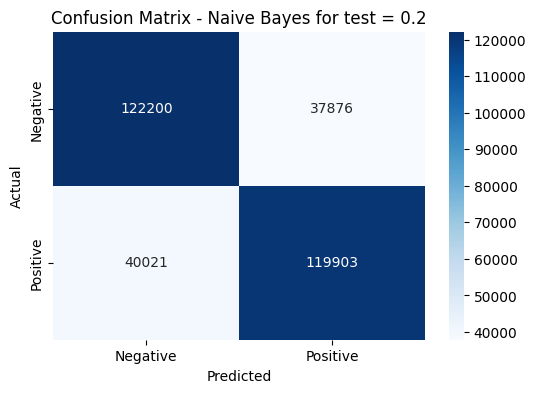

In [114]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes for test = 0.2')
plt.show()

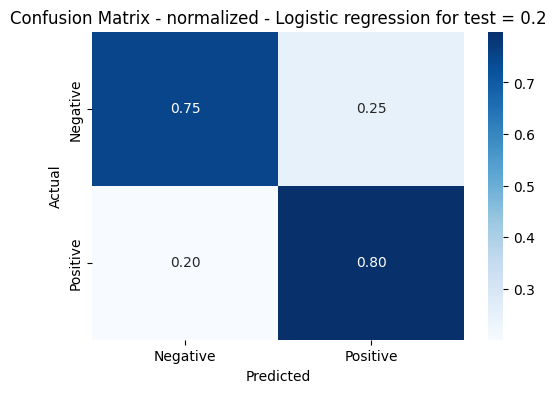

In [116]:
conf_matrix1_normalised = conf_matrix1.astype('float') / conf_matrix1.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix1_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - normalized - Logistic regression for test = 0.2')
plt.show()

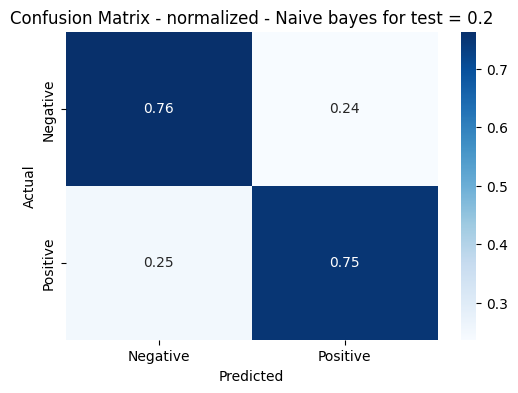

In [117]:
conf_matrix2_normalised = conf_matrix2.astype('float') / conf_matrix2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix2_normalised, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - normalized - Naive bayes for test = 0.2')
plt.show()


## 6.1 Checking how the model behaves when we change ratio of test/train set

Accuracy - Logistic regression for test size = 0.005 train size =  0.995
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      4003
           1       0.75      0.80      0.77      3997

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000

Accuracy - Logistic regression for test size = 0.035 train size =  0.965
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     27977
           1       0.76      0.80      0.78     28023

    accuracy                           0.77     56000
   macro avg       0.77      0.77      0.77     56000
weighted avg       0.77      0.77      0.77     56000

Accuracy - Logistic regression for test size = 0.065 train size =  0.935
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     51860
           1      

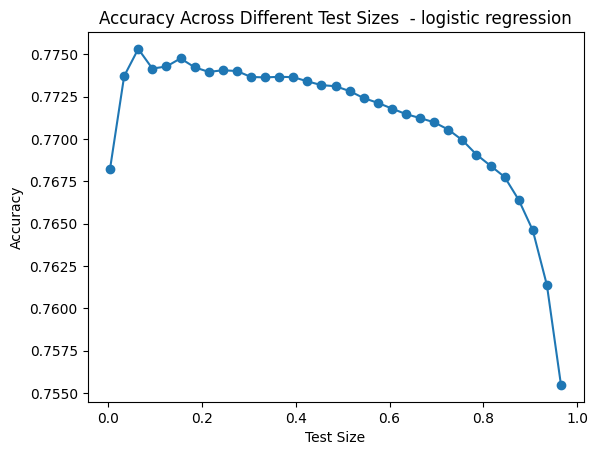

In [104]:
accuracies = []
for i in range(33):
    testsize = 0.005+i*0.03
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=9)
    model = LogisticRegression(max_iter=10000000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) #set is balanced so accuracy can be treated as an important metric.
    print("Accuracy - Logistic regression for test size =",round(testsize,3),"train size = ",round((1-testsize),3))
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracies.append(accuracy)
plt.plot(np.arange(0.005, 0.995, 0.03), accuracies, marker='o')
plt.title('Accuracy Across Different Test Sizes  - logistic regression')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.show()

## 6.2 Checking how the model behaves when the already pretrained set of vectors is used (instead of Tfidf vectorizer, WORD2VEC AND GLOVE )

### 6.2.1 WORD2VEC

In [118]:
'''googlenews-vectors-negative300.bin file is needed, download from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g
and later change the path'''

model_path = 'C:/Users/julek/OneDrive/Pulpit/szkoła/introductionML/GoogleNews-vectors-negative300.bin'
try:
    word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)
except ValueError as e:
    print(f"Error loading model: {e}")
    model = None

In [119]:
def get_tweet_vector(tweet):
    words = [word for word in tweet.split() if word in word_vectors]
    if not words:
        return np.zeros(300)  #vectors have 300 dimensions
    return np.mean(word_vectors[words], axis=0)

features = np.array([get_tweet_vector(tweet) for tweet in df['text']])

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=9)

# Step 3: Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy3}')
print(classification_report(y_test, y_pred))

Accuracy: 0.710446875
              precision    recall  f1-score   support

           0       0.72      0.69      0.70    160076
           1       0.70      0.73      0.72    159924

    accuracy                           0.71    320000
   macro avg       0.71      0.71      0.71    320000
weighted avg       0.71      0.71      0.71    320000



### 6.2.2 GLOVE

In [120]:
'''glove vectors with 300 dimensions needed'''
# Convert GloVe format to Word2Vec format
glove_file = 'C:/Users/julek/OneDrive/Pulpit/szkoła/introductionML/glove.6B.300d.txt'  # Adjust the file path to your GloVe file
word2vec_output_file = 'C:/Users/julek/OneDrive/Pulpit/szkoła/introductionML/twitter.27B.300d.word2vec'
glove2word2vec(glove_file, word2vec_output_file)

# Load the converted word vectors
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\julek\AppData\Local\Temp\ipykernel_24292\1851048631.py:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


In [121]:
def get_tweet_vector(tweet):
    words = [word for word in tweet.split() if word in word_vectors]
    if not words:
        return np.zeros(300)  # or any other default vector
    return np.mean(word_vectors[words], axis=0)

features = np.array([get_tweet_vector(tweet) for tweet in df['text']])

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=9)

# Step 3: Create and train the logistic regression model
model = LogisticRegression(max_iter=1000000)
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy4}')
print(classification_report(y_test, y_pred))

Accuracy: 0.694915625
              precision    recall  f1-score   support

           0       0.69      0.70      0.70    160076
           1       0.70      0.69      0.69    159924

    accuracy                           0.69    320000
   macro avg       0.69      0.69      0.69    320000
weighted avg       0.69      0.69      0.69    320000



# 7. Other approaches

## 7.1 KNN

In [125]:
model3 = KNeighborsClassifier(n_neighbors = 99) # for all data k = 99, because it's relatively close to square root of number of all tweets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
model3.fit(X_train, y_train)

y_pred = model3.predict(X_test[0:10000])
accuracy5 = accuracy_score(y_test[0:10000], y_pred)

print(f'Accuracy: {accuracy5:.2f}')

print(classification_report(y_test[0:10000], y_pred))


Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.56      0.90      0.69      4988
           1       0.75      0.30      0.43      5012

    accuracy                           0.60     10000
   macro avg       0.66      0.60      0.56     10000
weighted avg       0.66      0.60      0.56     10000



# 8. LSTM

In [ ]:

train_data, test_data = train_test_split(df, test_size=0.2,
                                         random_state=9)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = 20)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = 20)

print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Vocabulary Size : 227948
Training X Shape: (1280000, 20)
Testing X Shape: (320000, 20)


In [ ]:
labels = train_data.sentiment.unique().tolist()

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [ ]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    vocab_size,
    EMBEDDING_DIM,
    input_length=20,
    trainable=True  #Allow the model to update the embeddings during training
)

# Training - LSTM

In [ ]:
sequence_input = Input(shape=(20,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 10
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/2
1250/1250 [==============================] - 1279s 1s/step - loss: 0.4671 - accuracy: 0.7774 - val_loss: 0.4527 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 2/2
1250/1250 [==============================] - 1253s 1s/step - loss: 0.4124 - accuracy: 0.8099 - val_loss: 0.4578 - val_accuracy: 0.7840 - lr: 0.0010


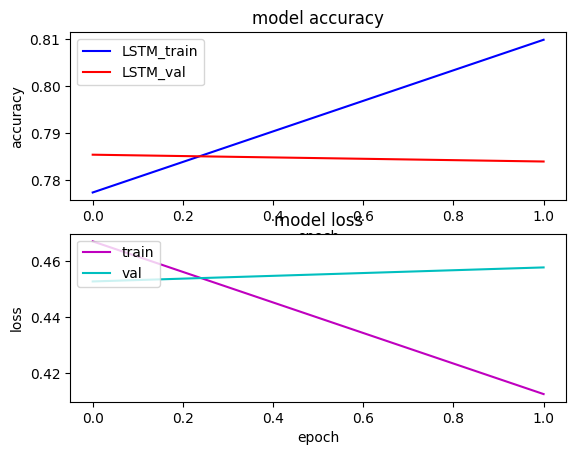

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0
scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 16s 485ms/step


In [ ]:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

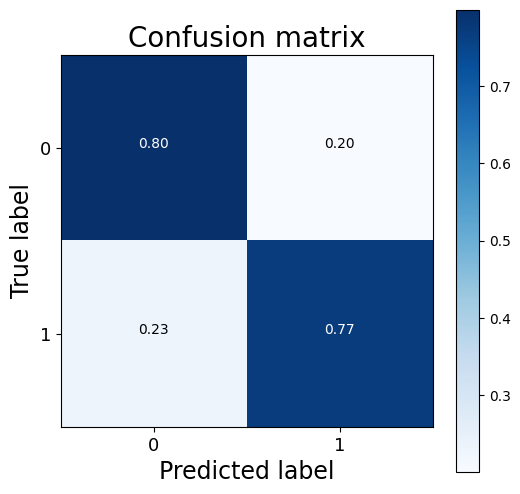

In [ ]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

In [ ]:
report = classification_report(list(test_data.sentiment), y_pred_1d)
print(report)
#accuracy_line = [line for line in report.split('\n') if line.startswith('accuracy')][0]
#accuracy7 = float(accuracy_line.split()[1])
accuracy6 = accuracy_score(list(test_data.sentiment), y_pred_1d)
"""jeszcze nie wiem co tu bedzie dokladnie"""

              precision    recall  f1-score   support

           0       0.78      0.80      0.79    160076
           1       0.79      0.77      0.78    159924

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# 9. COMPARISON

In [1]:
methods = ['Log. Reg. - tfidf  ', 'Naive B. - tfidf', 'Log. Reg. - Word2Vec', 'Log. Reg. - Glove', 'knn', 'LSTM']



accuracy_values = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6]


# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracy_values, color='blue')
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1
plt.title('Accuracy Comparison of Different Methods')
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.show()

NameError: name 'accuracy1' is not defined